# ZPEM2311 Major Project Download and Fit Example
This short example shows you how your `model.py` module should work and how to download COVID-19 data from the [Open COVID-19 Dataset](https://github.com/open-covid-19/data).

You should also look in the [examples folder](https://github.com/open-covid-19/data/tree/main/examples) of that repo for more examples of how to work with the data.

So first import some libraries, including your custom `model` library.

In [1]:
import pandas
from model import fit, predict
from plotly import graph_objs as go

## Temporary model module

Simple model:
$ y = C e^{kt}$

Derivative:
$\frac{dy}{dt} = ky$

In [62]:
from datetime import date

import pandas
from numpy import zeros, inf
from scipy.integrate import odeint
from scipy.optimize import curve_fit

def dydt(y, t, k):
    return k*y

def extract_t_from(X):
    dates = X['date'].apply(date.fromisoformat).tolist()
    return [(d - dates[0]).days for d in dates]

def model(t, y0, k):
    return odeint(dydt, y0, t, args=(k,))[:,0]

def fit(X: pandas.DataFrame, y: pandas.Series, **kwargs):
    """Fit a compartmental epidemiological model to COVID-19 data obtained from
    https://github.com/open-covid-19/data.

    Fits an ordinary differential equation to the y input. The independent
    variable is given by the "date" column of X, but there is other data in
    X that may be used to inform your model.

    Parameters
    ----------
    X : pandas.DataFrame
        A DataFrame containing at least the "date" columns

    y : pandas.Series
        A Series containing the response variable ("total_confirmed" cases)

    Returns
    -------
    dict
        Fitted model parameters.
    """

    # Model fitting code goes here
    t = extract_t_from(X)
    (y0, k), _ = curve_fit(model, t, y, bounds=((0, 0), (inf, inf)))
    return dict(y0=y0, k=k)


def predict(X: pandas.DataFrame, y0=1, k=0.0001, **kwargs):
    """Predict the number of confirmed cases of COVID-19 at the dates in the
    "date" column of data.

    Parameters
    ----------
    X : pandas.DataFrame
        A DataFrame containing at least a "date" column, but also containing
        covariate data that were used to fit the model. None of the
        following columns are used for prediction: "new_confirmed",
        "new_deceased", "new_recovered", "total_confirmed", "total_deceased",
        "total_recovered", "new_hospitalized", "total_hospitalized",
        "current_hospitalized", "new_intensive_care", "total_intensive_care",
        "current_intensive_care", "new_ventilator", "total_ventilator", and
        "current_ventilator".

    Keyword Arguments
    -----------------
    The model parameters.

    Returns
    -------
    array
        Array of floats giving the predicted number of confirmed COVID-19
        cases. Length is the number of rows in X.
    """

    # ODE integration code goes here

    t = extract_t_from(X)
    y_predicted = model(t, y0, k)
    
    return y_predicted

## Download from the Open COVID-19 Dataset
In this example I will download Australian data.

In [8]:
data = pandas.read_csv('https://storage.googleapis.com/covid19-open-data/v2/AU/main.csv')

Now split the data into what you're trying to predict and what you're using to predict it. We're trying to predict the "total_confirmed" column in that DataFrame, primarily based on the "date" column, but you are welcome to recruit any other data that might be useful.

The data we're trying to predict goes in `y`, and the data that we're using to make the predictions goes in `X`.

When I say "any", I mean except these columns, because they would make it too easy:
"new_confirmed", "new_deceased", "new_recovered", "total_confirmed", "total_deceased", "total_recovered", "new_hospitalized", "total_hospitalized", "current_hospitalized", "new_intensive_care", "total_intensive_care", "current_intensive_care", "new_ventilator", "total_ventilator", and "current_ventilator".

So let's remove them while we're here.

In [15]:
data = data[(data['date'] >= '2020-02-01') & (data['date'] < '2020-04-01')]

In [16]:
y = data['total_confirmed']

X = data.drop(columns=[
    "new_confirmed", "new_deceased", "new_recovered", 
    "total_confirmed", "total_deceased", "total_recovered",
    "new_hospitalized", "total_hospitalized", "current_hospitalized",
    "new_intensive_care", "total_intensive_care", 
    "current_intensive_care", "new_ventilator", "total_ventilator",
    "current_ventilator"
])

## Fit your model

In [63]:
params = fit(X, y)

## Interpret your parameters
The point of fitting these models is that they have meaning. For your project you should interpret the meaning of the parameters that you discovered. Your parameters will be different to mine.

In [64]:
pandas.DataFrame(dict(value=params))

,value
k,0.137997
y0,1.591599


## Validate your model
You will need to do more work to validate your model, but just to eyeball the results we will plot it along side the confirmed cases data.

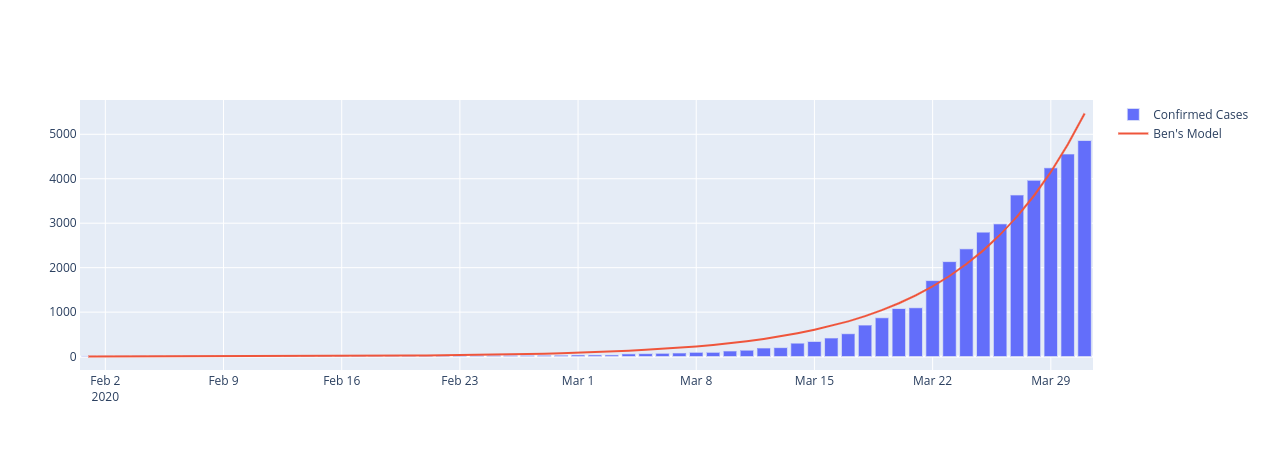

In [65]:
fig = go.Figure()
fig.add_trace(go.Bar(x=data['date'],
                     y=y,
                     name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=data['date'],
                         y=predict(X, **params),
                         name="Ben's Model"))
fig.show()